XGBoost est reconnu pour offrir une très bonne précision dans les tâches de régression, notamment grâce à sa structure en arbres de décision successifs. Il optimise les prédictions en corrigeant les erreurs des arbres précédents (boosting), ce qui le rend plus performant que des modèles simples comme la régression linéaire.

Nous avons choisi XGBoost comme premier modèle pour prédire la valeur marchande des joueurs en raison de ses nombreux avantages adaptés à ce type de problématique :

Très performant pour les tâches de régression grâce à l’approche du boosting qui corrige les erreurs à chaque itération.

Robuste aux valeurs extrêmes et bruitées, ce qui est fréquent dans les données footballistiques.

Capable de capturer des relations non linéaires complexes entre les caractéristiques du joueur (âge, poste, performance, etc.) et sa valeur marchande.

Fournit une interprétabilité utile : on peut savoir quelles variables influencent le plus la valeur prédite.

Rapide et efficace, même sur des datasets assez volumineux, ce qui permet de tester plusieurs versions rapidement.

Intègre des mécanismes pour éviter le surapprentissage, comme la régularisation.

En résumé, XGBoost représente un bon compromis entre précision, rapidité, robustesse et interprétabilité, ce qui en fait un excellent point de départ pour un projet de prédiction appliqué au football.

Comment on a testé la performance de XGBoost :
On a entraîné le modèle sur des données connues (ex. : joueurs avec une vraie valeur marchande).

On a testé le modèle sur d’autres joueurs qu’il n’a jamais vus pour voir s’il arrive à bien prédire leur valeur.

Pour mesurer la qualité des prédictions, on a utilisé des métriques comme :

MAE (erreur absolue moyenne) → "En moyenne, je me trompe de combien de millions ?"

RMSE (erreur quadratique moyenne) → "Je pénalise plus les grosses erreurs"

R² (score de qualité globale) → "Est-ce que le modèle explique bien les variations des valeurs ?"

On a aussi fait ça plusieurs fois avec des splits différents des données (validation croisée) pour s’assurer que ce n’était pas juste de la chance.



On a utilisé XGBoost comme premier choix, car c’est un modèle très performant par défaut, utilisé dans plein de compétitions.

On voulait d’abord avoir un modèle de base solide avant de perdre du temps à comparer avec 5 autres modèles.



In [38]:
import os
os.chdir('C:/Users/bahri/Desktop/Football_performance_analysis')

In [39]:
import os
print(os.getcwd())


C:\Users\bahri\Desktop\Football_performance_analysis


In [40]:
import pandas as pd
df = pd.read_excel('data/cleaned/sofifa/sofifa_players_cleaned.xlsx')

In [41]:
import pandas as pd
import unicodedata
import os

# Always create the directory in case it's missing
os.makedirs('data/cleaned/sofifa', exist_ok=True)

# Load the Excel file
df = pd.read_excel('data/cleaned/sofifa/sofifa_players_cleaned.xlsx')

exclude_col = 'Picture'

def remove_accents(text):
    if isinstance(text, str):
        text = unicodedata.normalize('NFKD', text)
        return ''.join(c for c in text if not unicodedata.combining(c))
    return text

def clean_string(value):
    if isinstance(value, str):
        value = remove_accents(value)
        value = value.strip().lower().replace(" ", "_")
    return value

def clean_dataframe(df, exclude_columns=None):
    if exclude_columns is None:
        exclude_columns = []

    # Clean column names
    df.columns = [clean_string(col) for col in df.columns]

    # Clean object columns except excluded
    for col in df.select_dtypes(include=['object']).columns:
        if col not in exclude_columns:
            df[col] = df[col].apply(clean_string)
    
    return df

# Remove dots in the 'name' column if it exists
if 'name' in df.columns:
    df['name'] = df['name'].str.replace('.', '', regex=False)

# Clean the DataFrame
df_cleaned = clean_dataframe(df, exclude_columns=[exclude_col])
df_cleaned['market_value_million'] = (df_cleaned['value'] / 1_000_000).round(1)
df_cleaned['wage_k'] = (df_cleaned['wage'] / 1_000).round(1)


# Save cleaned version
output_path = 'data/cleaned/sofifa/sofifa_players_clnd.xlsx'
df_cleaned.to_excel(output_path, index=False)
print(f"✅ Data cleaned and saved to: {output_path}")


KeyError: 'value'

In [ ]:
df = pd.read_excel('data/cleaned/sofifa/sofifa_players_cleaned.xlsx')

In [ ]:
df['foot'] = df['foot'].map({'left': 0, 'right': 1})
df = pd.get_dummies(df, columns=['best_position', 'body_type'], drop_first=False)

KeyError: 'foot'

In [ ]:

# Convert all True/False to 1/0
df_preprocessed = df.replace({'VRAI': 1, 'FAUX': 0})
# or, better for bool dtype columns:
df_preprocessed = df.astype({col: int for col in df_preprocessed.select_dtypes(include='bool').columns})
df_preprocessed.to_excel('data/cleaned/sofifa/sofifa_players_clnd.xlsx', index=False)


In [ ]:
# Contract length
df['contract_length'] = df['contract_end'] - df['contract_start']
# Create age groups: young (<=23), peak (24-28), veteran (>28)
df['age_group'] = pd.cut(df['age'], bins=[16, 23, 28, 40], labels=['young', 'peak', 'veteran'])
# One-hot encode age_group (drop_first=True to avoid dummy variable trap)
df = pd.get_dummies(df, columns=['age_group'], drop_first=False)



In [ ]:
df = df.replace({'VRAI': 1, 'FAUX': 0})
# or, better for bool dtype columns:
df = df.astype({col: int for col in df.select_dtypes(include='bool').columns})
df.to_excel('data/cleaned/sofifa/sofifa_players_clnd.xlsx', index=False)

In [ ]:
import os
os.chdir("c:/Users/bahri/Desktop/Football_performance_analysis")


In [42]:
import pandas as pd
df=pd.read_excel('data/cleaned/sofifa/sofifa_players.xlsx')

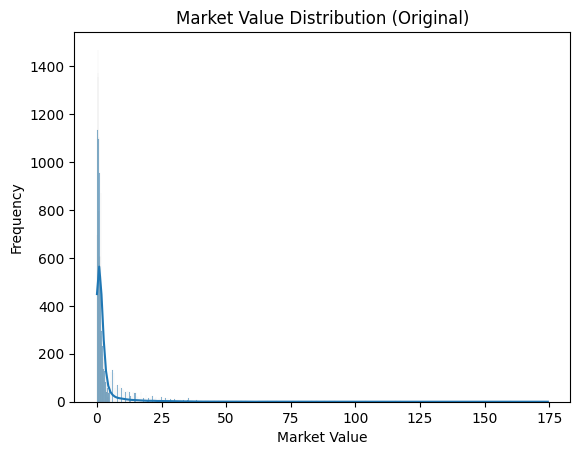

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['market_value_m'], kde=True)
plt.title("Market Value Distribution (Original)")
plt.xlabel("Market Value")
plt.ylabel("Frequency")
plt.show()


If skewness > +1, the data is highly right-skewed

If 0.5 < skewness ≤ 1, it's moderately right-skewed

If skewness ~ 0, it's approximately symmetric

In [44]:
from scipy.stats import skew

original_skew = skew(df['market_value_m'].dropna())
print(f"Original Skewness: {original_skew:.2f}")


Original Skewness: 8.43


In [45]:
import numpy as np


df['log_market_value'] = np.log1p(df['market_value_m'])  # log(1 + x)

In [46]:
from scipy.stats import skew
print("Skew after log transform:", skew(df['log_market_value'].dropna()))


Skew after log transform: 1.872792285034762


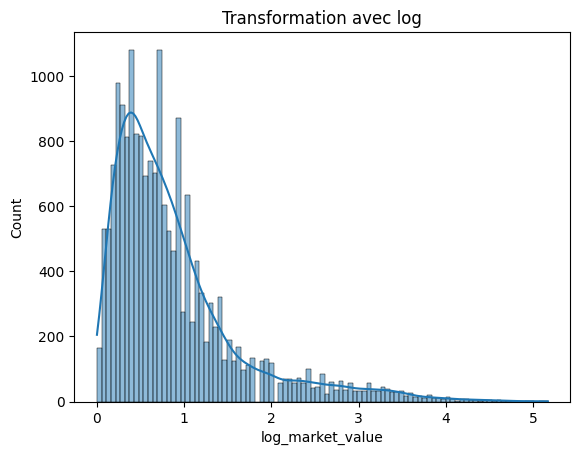

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['log_market_value'], kde=True)
plt.title("Transformation avec log")
plt.show()

le log a trop compressé les grandes valeurs.donc on va essayer une autre methode

In [51]:
df=pd.read_excel("merged_players.xlsx")

Lambda utilisé: 0.15653575047456134
Skew après Box-Cox: 0.0640279744615235


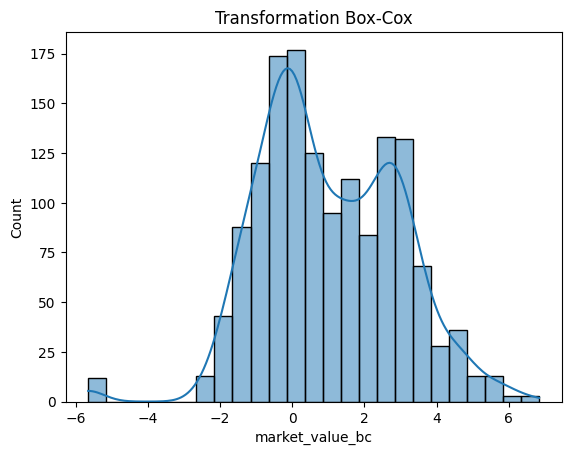

In [53]:
from scipy.stats import boxcox

df['market_value_bc'], fitted_lambda = boxcox(df['value_m'] + 1e-6)  # éviter les zéros
print("Lambda utilisé:", fitted_lambda)
print("Skew après Box-Cox:", skew(df['market_value_bc'].dropna()))
sns.histplot(df['market_value_bc'], kde=True)
plt.title("Transformation Box-Cox")
plt.show()


maintenant on une distribution bien équilibrée, sans queue dominante à gauche ou à droite.

on doit pas oublier de tu appliquer l’inverse de Box-Cox pour retrouver les vraies valeurs.

on doit choisir les bonnes features a utiliser premierement 

Calculer les corrélations numériques avec la cible pour les eliminer les fortes corrélations

entrainement avec la variable cible transformée par le log

In [54]:
import pandas as pd

# Suppose que df est ton DataFrame et 'market_value_m' est la variable cible
correlations = df.corr(numeric_only=True)['market_value_m'].sort_values(ascending=False)

print(correlations)


KeyError: 'market_value_m'

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb

# Define your features and target
features = [
    'age',
    'height',
    'weight',
    'overall_rating',
    'potential',
    'best_overall',
    'international_reputation',
    'skill_moves',
    'weak_foot',
    
    # Statistiques globales
    'base_stats',
    'total_stats',
    'total_attacking',
    'total_skill',
    'total_movement',
    'total_power',
    'total_mentality',
    'total_defending',
    'total_goalkeeping',
    
    # Attributs techniques
    'short_passing',
    'long_passing',
    'crossing',
    'finishing',
    'heading_accuracy',
    'curve',
    'dribbling',
    'ball_control',
    'long_shots',
    'fk_accuracy',
    'penalties',
    
    # Attributs physiques / mouvement
    'acceleration',
    'sprint_speed',
    'agility',
    'balance',
    'reactions',
    'jumping',
    'stamina',
    'strength',
    
    # Mental
    'aggression',
    
    # Défense
    'defensive_awareness',
    'standing_tackle',
    'sliding_tackle'
]

X = df[features]
y = df['log_market_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)



In [ ]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
y_pred_log = model.predict(X_test)
y_pred_real = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)


In [ ]:
# Predict
y_pred = model.predict(X_test)


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("MAE:", mean_absolute_error(y_test_real, y_pred_real))
print("RMSE:", np.sqrt(mean_squared_error(y_test_real, y_pred_real)))
print("R²:", r2_score(y_test_real, y_pred_real))





MAE: 0.35960873601887444
RMSE: 2.221002237629971
R²: 0.919075174836372


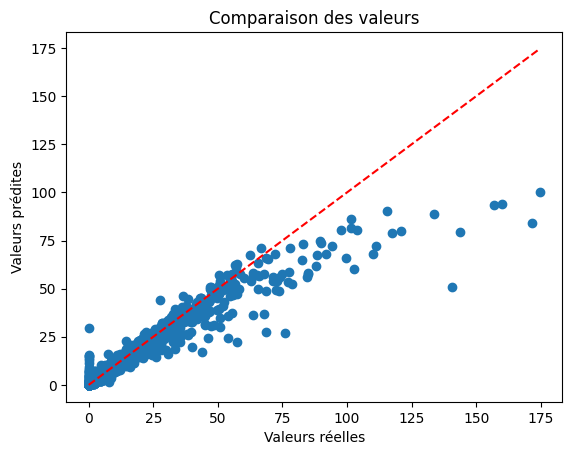

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test_real, y_pred_real)
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.title("Comparaison des valeurs")
plt.plot([min(y_test_real), max(y_test_real)], [min(y_test_real), max(y_test_real)], 'r--')  # diagonale parfaite
plt.show()


In [ ]:
import numpy as np
comparison_df = pd.DataFrame({
    'Actual (€M)': np.expm1(y_test),
    'Predicted (€M)': np.expm1(model.predict(X_test))
})
print(comparison_df.head(10))


       Actual (€M)  Predicted (€M)
18229          0.1        0.092535
2480           3.8        4.372221
12727          0.8        0.918570
4128           1.6        1.571609
6827           2.0        2.112266
1710           1.9        1.810383
11359          0.7        0.605523
9248           1.2        1.230873
828           12.0       12.090456
3194           3.0        3.258698


In [ ]:
import matplotlib.pyplot as plt

xgb.plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()


NameError: name 'xgb' is not defined

entrainement du modele avec la variable cible transformée avec box cox

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Séparation des données
features = [
    'age',
    'height',
    'weight',
    'overall_rating',
    'potential',
    'best_overall',
    'international_reputation',
    'skill_moves',
    'weak_foot',
    
    # Statistiques globales
    'base_stats',
    'total_stats',
    'total_attacking',
    'total_skill',
    'total_movement',
    'total_power',
    'total_mentality',
    'total_defending',
    'total_goalkeeping',
    
    # Attributs techniques
    'short_passing',
    'long_passing',
    'crossing',
    'finishing',
    'heading_accuracy',
    'curve',
    'dribbling',
    'ball_control',
    'long_shots',
    'fk_accuracy',
    'penalties',
    
    # Attributs physiques / mouvement
    'acceleration',
    'sprint_speed',
    'agility',
    'balance',
    'reactions',
    'jumping',
    'stamina',
    'strength',
    
    # Mental
    'aggression',
    
    # Défense
    'defensive_awareness',
    'standing_tackle',
    'sliding_tackle'
]

X = df[features]  # ou garde seulement les features utiles
y = df['market_value_bc']  # Valeur transformée

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle
model = XGBRegressor()
model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
y_pred_transformed = model.predict(X_test)


In [ ]:
from scipy.special import inv_boxcox

y_pred_real_2 = inv_boxcox(y_pred_transformed, fitted_lambda)
y_test_real_2 = inv_boxcox(y_test, fitted_lambda)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("MAE:", mean_absolute_error(y_test_real_2, y_pred_real_2))
print("RMSE:", np.sqrt(mean_squared_error(y_test_real_2, y_pred_real_2)))
print("R²:", r2_score(y_test_real_2, y_pred_real_2))


MAE: 0.3715148682758786
RMSE: 1.6329971747957528
R²: 0.9549173132705688


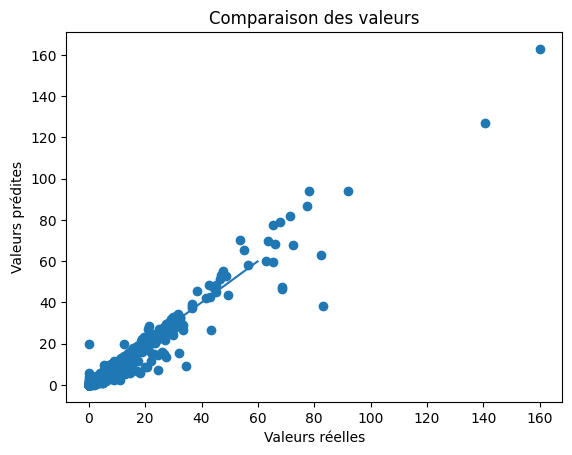

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test_real_2, y_pred_real_2)
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.title("Comparaison des valeurs")
plt.plot([min(y_test_real), max(y_test_real)], [min(y_test_real), max(y_test_real)], 'r--')  # diagonale parfaite
plt.show()


MAE (erreur absolue moyenne) est très similaire entre les deux (différence de 10–15 k€), donc les deux modèles font en moyenne des erreurs proches.

RMSE (erreur quadratique) est nettement meilleure avec Box-Cox, ce qui signifie que les grosses erreurs sont mieux maîtrisées.

R² (coefficient de détermination) est meilleur avec Box-Cox → il explique plus de variance dans les données.

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

model = XGBRegressor(random_state=42)
grid = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error', verbose=1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Meilleurs hyperparamètres :", grid.best_params_)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Meilleurs hyperparamètres : {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


max_depth=7 → le modèle capte des relations plus complexes.

learning_rate=0.05 → Apprentissage plus lent mais plus précis (très bon).

colsample_bytree=0.8 → 80% des colonnes sont échantillonnées à chaque arbre → bon pour la diversité des arbres.

subsample=1 → Il prend 100% des lignes à chaque arbre (tu pourrais tester 0.8 pour voir si ça améliore la robustesse).

n_estimators=100 → 100 arbres = bon équilibre entre performance et temps de calcul.



In [ ]:
from xgboost import XGBRegressor

best_model = XGBRegressor(
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=7,
    n_estimators=100,
    subsample=1,
    random_state=42
)

best_model.fit(X_train, y_train)

# Prédictions
y_pred_trans = best_model.predict(X_test)

# Inverser Box-Cox
from scipy.special import inv_boxcox
y_pred_real = inv_boxcox(y_pred_trans, fitted_lambda)
y_test_real = inv_boxcox(y_test, fitted_lambda)

# Évaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("MAE:", mean_absolute_error(y_test_real, y_pred_real))
print("RMSE:", np.sqrt(mean_squared_error(y_test_real, y_pred_real)))
print("R²:", r2_score(y_test_real, y_pred_real))


MAE: 0.2907288355492672
RMSE: 1.3751998256558473
R²: 0.9680279457894805


 Erreur réduite de ~22% 


Erreur quadratique réduite


 Pouvoir explicatif renforcé

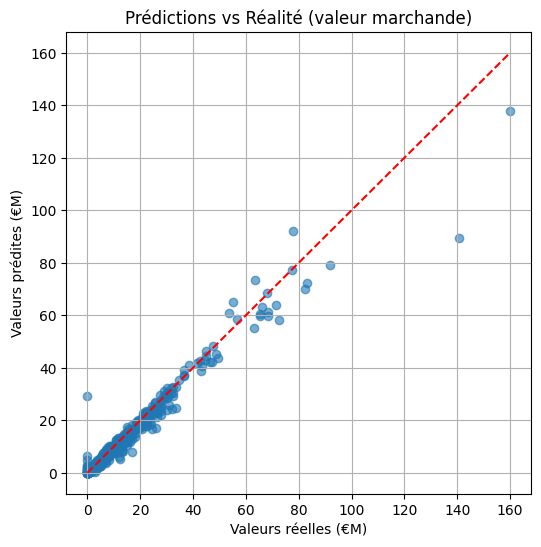

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test_real, y_pred_real, alpha=0.6)
plt.plot([min(y_test_real), max(y_test_real)],
         [min(y_test_real), max(y_test_real)],
         color='red', linestyle='--')
plt.xlabel("Valeurs réelles (€M)")
plt.ylabel("Valeurs prédites (€M)")
plt.title("Prédictions vs Réalité (valeur marchande)")
plt.grid(True)
plt.show()


On va utiliser RandomForestRegressor pour prédire market_value_m (via market_value_bc) et comparer ses performances à XGBoost.



In [55]:

from sklearn.model_selection import train_test_split

# Séparation des données
features = [
    'release_clause_m', 'international_reputation',
    'overall_rating', 'reactions', 'potential', 'composure',
    'vision', 'wage_k', 'shortpassing', 'ballcontrol'
]

X = df[features]  # ou garde seulement les features utiles
y = df['market_value_bc']  # Valeur transformée

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [56]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [57]:
from scipy.special import inv_boxcox

y_pred_trans = rf_model.predict(X_test)
y_pred_real = inv_boxcox(y_pred_trans, fitted_lambda)
y_test_real = inv_boxcox(y_test, fitted_lambda)


In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2 = r2_score(y_test_real, y_pred_real)

print("📊 Résultats RandomForest :")
print(f"MAE : {mae:.4f} M€")
print(f"RMSE : {rmse:.4f} M€")
print(f"R² : {r2:.4f}")


📊 Résultats RandomForest :
MAE : 0.4214 M€
RMSE : 1.3631 M€
R² : 0.9846


In [60]:
X_test_copy = X_test.copy()
X_test_copy["true_value"] = y_test_real
X_test_copy["predicted_value"] = y_pred_real
X_test_copy["name"] = df.loc[X_test.index, "name"]

# Exemple de joueurs connus
exemples = ["kylian_mbappe"]
df_sample = X_test_copy[X_test_copy["name"].isin(exemples)]

# Sauvegarde et affichage
print(df_sample[["name", "true_value", "predicted_value"]])

Empty DataFrame
Columns: [name, true_value, predicted_value]
Index: []


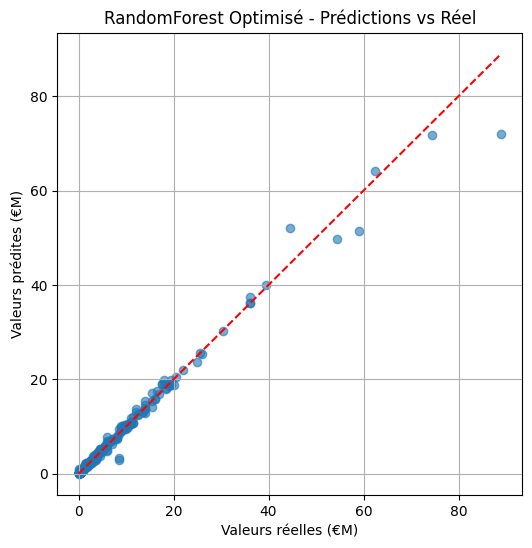

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test_real, y_pred_real, alpha=0.6)
plt.plot([min(y_test_real), max(y_test_real)],
         [min(y_test_real), max(y_test_real)],
         color='red', linestyle='--')
plt.xlabel("Valeurs réelles (€M)")
plt.ylabel("Valeurs prédites (€M)")
plt.title("RandomForest Optimisé - Prédictions vs Réel")
plt.grid(True)
plt.show()

In [ ]:
import joblib
import json

joblib.dump(rf_model, 'best_randomforest_market_value_model.pkl')
print("✅ Modèle sauvegardé sous : best_randomforest_market_value_model.pkl")

# Save fitted_lambda
with open('boxcox_lambda.json', 'w') as f:
    json.dump({'lambda': fitted_lambda}, f)

# Save feature list
with open('selected_features.json', 'w') as f:
    json.dump(features, f)



✅ Modèle sauvegardé sous : best_randomforest_market_value_model.pkl
